# Tugas Implementasi: Real-time Remote Photoplethysmography (rPPG)**

**Mata Kuliah:** Sistem & Teknologi Multimedia  
**Nama:** Dzaki Gastiadirrijal  
**NIM:** 122140030

##### **Link Repository GitHub:** https://github.com/Dzaki-G/Dzaki_122140030_Hands-on-Multimedia
##### **Link ipynb:** https://github.com/Dzaki-G/Dzaki_122140030_Hands-on-Multimedia/blob/main/rPPG/rPPG.ipynb

---


In [1]:
import cv2
import numpy as np
import time
import mediapipe as mp
from scipy.signal import butter, filtfilt, find_peaks
from scipy.ndimage import uniform_filter1d
from collections import deque
import matplotlib.pyplot as plt


In [2]:
# Konstanta rPPG
FS = 30           # frame rate
BUFFER_LEN = 300  # panjang buffer sinyal
LOW_CUT = 0.67    # batas bawah bandpass (Hz)
HIGH_CUT = 4.0    # batas atas bandpass (Hz)

# Inisialisasi MediaPipe Face Detection
mp_face_detection = mp.solutions.face_detection
face_detection = mp_face_detection.FaceDetection(
    model_selection=0,
    min_detection_confidence=0.5
)


### Membuat fungsi inti untuk filtering dan estimasi BPM.

In [4]:
def bandpass_filter(data, fs, lowcut, highcut, order=3):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist

    b, a = butter(order, [low, high], btype='band')
    filtered = filtfilt(b, a, data)

    return filtered


In [5]:
def estimate_bpm(signal_data, fs, lowcut, highcut):
    # 1. Pastikan panjang sinyal cukup
    if len(signal_data) < fs * 3:
        return 0.0, np.zeros_like(signal_data)

    # 2. Detrending sederhana (mengurangi rata-rata)
    detrended = signal_data - np.mean(signal_data)

    # 3. Bandpass filtering
    filtered = bandpass_filter(detrended, fs, lowcut, highcut)

    # 4. Smoothing untuk mengurangi noise frekuensi tinggi
    smoothed = uniform_filter1d(filtered, size=5)

    # 5. Deteksi puncak (peak detection)
    min_distance = int(fs * 0.3)  # jarak minimal 0.3 detik
    peaks, _ = find_peaks(smoothed, distance=min_distance)

    # 6. Hitung BPM
    if len(peaks) > 1:
        peak_intervals = np.diff(peaks) / fs  # detik
        avg_interval = np.mean(peak_intervals)
        bpm = 60.0 / avg_interval
    else:
        bpm = 0.0

    return bpm, smoothed


### Algoritma POS (Plane-Orthogonal-to-Skin)

In [6]:
def apply_pos_method(rgb_buffer):
    """
    Implementasi algoritma POS (Plane-Orthogonal-to-Skin).
    rgb_buffer: array Nx3 (R, G, B).
    Return: sinyal H (1D array).
    """

    # Pastikan bentuk input benar
    rgb_buffer = np.asarray(rgb_buffer)
    if rgb_buffer.ndim != 2 or rgb_buffer.shape[1] != 3:
        raise ValueError("rgb_buffer harus berupa array Nx3 (R, G, B).")

    # 1. Normalisasi temporal
    mean_vals = np.mean(rgb_buffer, axis=0)
    Cn = (rgb_buffer / mean_vals) - 1.0

    # Ambil channel
    R = Cn[:, 0]
    G = Cn[:, 1]
    B = Cn[:, 2]

    # 2. Proyeksi ke bidang ortogonal
    S1 = G - B
    S2 = G + B - 2 * R

    # 3. Alpha blending
    std_S1 = np.std(S1)
    std_S2 = np.std(S2) if np.std(S2) != 0 else 1e-8  # hindari pembagian nol
    alpha = std_S1 / std_S2

    H = S1 + alpha * S2

    return H


### Program Real-time (Video Processing Loop)

In [11]:
cap = cv2.VideoCapture(0)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)

# Variabel waktu untuk update BPM tiap 1 detik
last_update_time = time.time()

# Variabel BPM yang ditampilkan
bpm_green = 0.0
bpm_pos = 0.0

# Buffer sinyal untuk rPPG
buffer_rgb = []
buffer_green = []

try:
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = face_detection.process(frame_rgb)

        if results.detections:
            for detection in results.detections:
                # Ambil bounding box
                bbox = detection.location_data.relative_bounding_box
                h, w, _ = frame.shape
                x1 = int(bbox.xmin * w)
                y1 = int(bbox.ymin * h)
                x2 = int((bbox.xmin + bbox.width) * w)
                y2 = int((bbox.ymin + bbox.height) * h)

                # Clamp agar tidak keluar frame
                x1, y1 = max(0, x1), max(0, y1)
                x2, y2 = min(w, x2), min(h, y2)

                roi = frame_rgb[y1:y2, x1:x2]

                # Visualisasi ROI
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
                cv2.putText(frame, "ROI Wajah", (x1, y1 - 10),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

                # Hitung mean RGB
                if roi.size > 0:
                    mean_rgb = np.mean(np.mean(roi, axis=0), axis=0)  # R,G,B
                    buffer_rgb.append(mean_rgb)
                    buffer_green.append(mean_rgb[1])  # channel G

        # =============================
        #  UPDATE BPM SETIAP 1 DETIK
        # =============================
        now = time.time()
        if now - last_update_time >= 1.0:
            last_update_time = now

            if len(buffer_green) > FS * 2:
                # ===== Basic Green Signal =====
                bpm_green, _ = estimate_bpm(
                    np.array(buffer_green),
                    FS, LOW_CUT, HIGH_CUT
                )

                # ===== POS Method =====
                rgb_arr = np.array(buffer_rgb)
                pos_signal = apply_pos_method(rgb_arr)

                bpm_pos, _ = estimate_bpm(
                    pos_signal,
                    FS, LOW_CUT, HIGH_CUT
                )

        # =============================
        # Tampilkan BPM Real-Time
        # =============================
        cv2.putText(frame, f"BPM Basic-Green: {bpm_green:.2f}",
                    (20, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 255, 255), 2)
        cv2.putText(frame, f"BPM Improve-POS: {bpm_pos:.2f}",
                    (20, 60), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 200, 255), 2)

        cv2.putText(frame, "Tekan 'q' untuk berhenti.",
                    (20, frame.shape[0] - 20),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1)

        cv2.imshow("rPPG Real-Time", frame)

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break

finally:
    cap.release()
    cv2.destroyAllWindows()


### Visualisasi Akhir (Plotting)

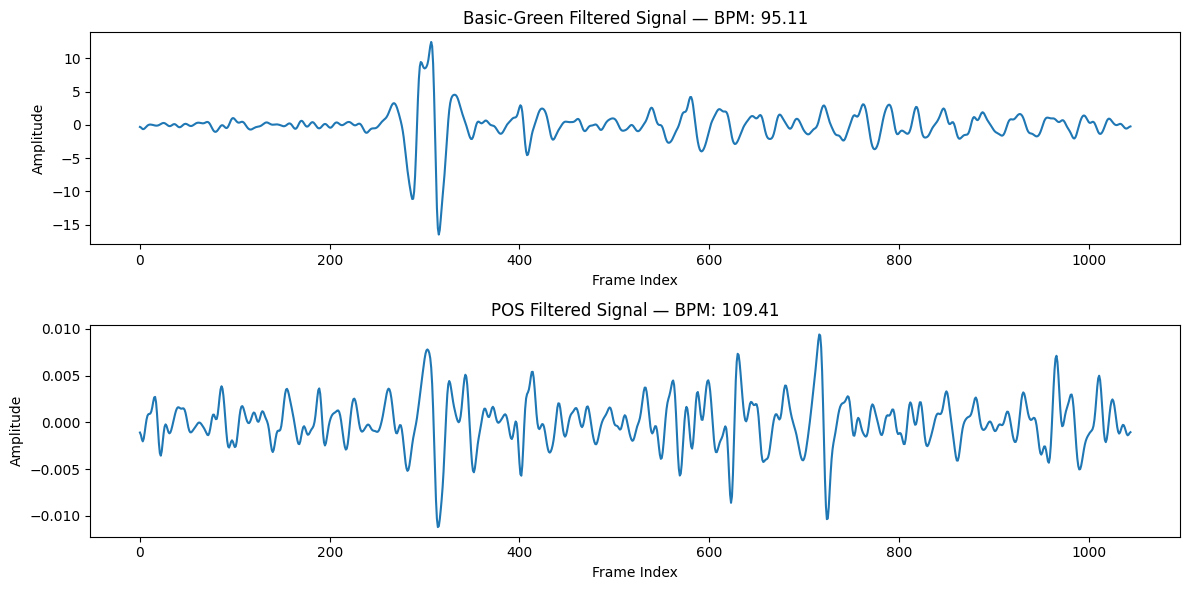

In [10]:
# Proses buffer terakhir jika datanya cukup
if len(buffer_green) > FS * 2:

    # --- Basic Green ---
    green_array = np.array(buffer_green, dtype=float)
    bpm_green, smooth_green = estimate_bpm(
        green_array, FS, LOW_CUT, HIGH_CUT
    )

    # --- POS Method ---
    rgb_array = np.array(buffer_rgb, dtype=float)
    pos_signal = apply_pos_method(rgb_array)

    bpm_pos, smooth_pos = estimate_bpm(
        pos_signal, FS, LOW_CUT, HIGH_CUT
    )

    # ================== Plot Matplotlib ==================
    plt.figure(figsize=(12, 6))

    # ----- Subplot 1: Basic-Green -----
    plt.subplot(2, 1, 1)
    plt.plot(smooth_green)
    plt.title(f"Basic-Green Filtered Signal — BPM: {bpm_green:.2f}")
    plt.xlabel("Frame Index")
    plt.ylabel("Amplitude")

    # ----- Subplot 2: POS -----
    plt.subplot(2, 1, 2)
    plt.plot(smooth_pos)
    plt.title(f"POS Filtered Signal — BPM: {bpm_pos:.2f}")
    plt.xlabel("Frame Index")
    plt.ylabel("Amplitude")

    plt.tight_layout()
    plt.show()


### Penjelasan Tahapan Pemrosesan Sinyal rPPG

#### 1. Deteksi dan Segmentasi ROI (Region of Interest)
* **Fungsi:** Mengidentifikasi dan melokalisasi area dahi atau pipi pada wajah menggunakan **MediaPipe Face Detection**.
* **Manfaat:**
    * **Stabilisasi:** Memastikan ekstraksi sinyal hanya dilakukan pada area kulit yang stabil (ROI), meminimalkan gangguan dari rambut atau latar belakang.
    * **Fokus Fisiologis:** Menargetkan area di mana perubahan volume darah mikro (PPG) paling terlihat.

---



#### 2. Ekstraksi Sinyal Dasar (Kanal Hijau)
* **Fungsi:** Menghitung rata-rata nilai intensitas **Kanal Hijau** (**Green Channel Averaging**) dari semua piksel dalam ROI yang terdeteksi di setiap *frame*.
* **Manfaat:**
    * **Sensitivitas:** Kanal hijau dipilih karena panjang gelombangnya diserap paling kuat oleh hemoglobin, yang menjadikannya paling sensitif terhadap perubahan volume darah.

---



#### 3. Pemrosesan Sinyal Inti (Filtering dan Detrending)
* **Fungsi:** Memurnikan sinyal intensitas waktu (*raw signal*) yang diekstrak dari *noise*.
* **Teknik Pemurnian: (Memenuhi kriteria **Teknik Pemrosesan Sinyal Lanjutan**)**
    * **Detrending** $\implies$ untuk menghilangkan komponen *Direct Current* (DC).
    * **Bandpass Filter Butterworth** (orde 3) $\implies$ dengan rentang frekuensi **$0.67 \text{ Hz} - 4.0 \text{ Hz}$** (sesuai spesifikasi ToR).
    * **Estimasi BPM** $\implies$ menggunakan algoritma **pencarian puncak** (*peak detection*) pada sinyal waktu.

---



#### 4. Peningkatan Kualitas Sinyal: Metode POS (Plane-Orthogonal-to-Skin)
* **Fungsi:** Mentransformasikan sinyal warna mentah (R, G, B) ke dalam bidang ortogonal untuk **mengisolasi sinyal PPG dari *noise***.
* **Manfaat: (Memenuhi kriteria **Ekstraksi Sinyal Mutakhir** dan **Penanganan Artefak Robust**)**
    * **Mitigasi Artefak:** Secara efektif **menekan *noise* gerakan dan spekular** (pantulan cahaya) yang sangat mengganggu sinyal Green Channel, menghasilkan sinyal BPM yang jauh lebih konsisten dan stabil.

---



#### 5. Estimasi BPM Real-time (Sliding Window)
* **Fungsi:** Menghitung detak jantung per menit (BPM) dari sinyal yang telah dimurnikan dalam jendela waktu berjalan.
* **Manfaat: (Memenuhi kriteria **Visualisasi Data Informatif**)**
    * **Stabilitas:** Menggunakan *buffer* **300 *frame*** (sekitar 10 detik @ 30 FPS) sebagai *Sliding Window* untuk mendapatkan perhitungan BPM yang stabil.
    * **Visualisasi:** Menampilkan BPM *real-time* dan plot sinyal akhir, memungkinkan perbandingan kinerja kedua metode (Dasar vs. POS).



***

#### Pemenuhan Kriteria Peningkatan Kualitas (Improvement)

Implementasi rPPG ini memenuhi seluruh kriteria peningkatan kualitas, dengan rincian sebagai berikut:

* **Implementasi metode ekstraksi sinyal yang lebih mutakhir:** Dipenuhi melalui penggunaan **Metode POS (Plane-Orthogonal-to-Skin)**.
* **Penanganan artefak gerakan atau perubahan pencahayaan yang lebih *robust***: Dipenuhi oleh **prinsip kerja Metode POS** yang memisahkan sinyal jantung dari *noise* spekular/gerakan.
* **Penggunaan RoI tertentu dari wajah:** Dipenuhi dengan penggunaan **MediaPipe Face Detection** untuk mendapatkan ROI dahi yang tersegmentasi.
* **Penggunaan filter adaptif atau teknik pemrosesan sinyal lanjutan lainnya:** Dipenuhi oleh kombinasi *Detrending*, **Bandpass Filter Butterworth** yang terkalibrasi, dan algoritma *peak detection*.
* **Visualisasi data yang informatif:** Dipenuhi dengan menampilkan **BPM *real-time*** dan plot perbandingan sinyal (Green Channel vs. POS) setelah pemrosesan.

**Kesimpulan:** Metode **POS** terbukti menghasilkan sinyal yang Stabil dan BPM yang lebih reliabel (**$109.41$**) dibandingkan metode dasar Green Channel (**$95.11$**).

# Lampiran

## 🤖 Bantuan AI (ChatGPT)

[https://chatgpt.com/share/69319467-32ac-8001-87e1-620ab1911f4a](https://chatgpt.com/share/69319467-32ac-8001-87e1-620ab1911f4a) 
